In [1]:
# pip install transformers torch pandas scikit-learn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

path = "drive/MyDrive/HealthML/final_project_files/"
train = pd.read_csv(path + "Processed_Dataset/train_processed.csv")
val = pd.read_csv(path + "Processed_Dataset/val_processed.csv")
test = pd.read_csv(path + "Processed_Dataset/test_processed.csv")

In [17]:
# df = pd.concat([train, val, test])
# df['ID'].nunique()

# Model Preparation

Load the ClinicalBERT model with a classification head from the Hugging Face transformers library: https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT?text=Paris+is+the+%5BMASK%5D+of+France.

In [29]:
from transformers import BertTokenizer, BertForSequenceClassification, logging
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Suppress info messages from transformers (optional, not necessary)
logging.set_verbosity_warning()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Load Bio_ClinicalBERT with Classification Head
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=1,
    ignore_mismatched_sizes=True  # This will suppress the warnings about mismatch sizes
)

# Class for handling tokenization
class NotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Ensure all sequences are padded to the same length
            truncation=True,  # Ensure that sequences longer than model max are truncated
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float) ### SELF - changed dtype to torch.float from torch.long
        }

def create_data_loader(df, tokenizer, batch_size, max_len=512):
    ds = NotesDataset(
        texts=df.TEXT.to_numpy(),
        labels=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

batch_size = 32
train_data_loader = create_data_loader(train, tokenizer, batch_size)
val_data_loader = create_data_loader(val, tokenizer, batch_size)
test_data_loader = create_data_loader(test, tokenizer, batch_size)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * 10  # 10 is the number of epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    total_batches = len(data_loader)
    for step, d in tqdm(enumerate(data_loader), total=len(data_loader), desc="Training", position=0, leave=True):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        model.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Print progress every 200 batches ### SELF changed to 200 instead of 10
        if (step + 1) % 200 == 0 or step == total_batches - 1:
            print(f'Batch {step + 1}/{total_batches}, Loss: {loss.item():.4f}')

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

# Hyperparameter Tuning - worth it?

---



In [36]:
def evaluate_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

In [37]:
small_train = train.sample(frac=0.1, random_state=42)
small_val = val.sample(frac=0.1, random_state=42)

In [38]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import AdamW, get_scheduler

def objective(trial):
    # Define hyperparameter search space
    learning_rate = trial.suggest_float("lr", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Create dataloaders with the suggested batch size
    train_loader = create_data_loader(small_train, tokenizer, batch_size)
    val_loader = create_data_loader(small_val, tokenizer, batch_size)

    # Initialize model and optimizer
    model = BertForSequenceClassification.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",
        num_labels=1,   ### SELF - changed to 1
        ignore_mismatched_sizes=True
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,  # You can adjust this if needed
        num_training_steps=len(train_loader) * 10  # Assuming 10 epochs
    )

    # Train for 1 epoch to validate performance
    train_acc, train_loss = train_epoch(
        model, train_loader, optimizer, device, scheduler, len(small_train)
    )
    val_acc, val_loss = evaluate_model(
        model, val_loader, device, len(small_val)
    )

    return val_loss  # Minimize validation loss

# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)

[I 2024-12-07 20:10:12,897] A new study created in memory with name: no-name-63cccfdc-fce8-47ff-beec-adf636388cbc
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:  53%|█████▎    | 190/356 [01:51<01:37,  1.71it/s]

# Training

In [31]:
import os

# Define a directory to save checkpoints
checkpoint_dir = "drive/MyDrive/HealthML/final_project/checkpoints"  # Adjust the path
os.makedirs(checkpoint_dir, exist_ok=True) # Create directory if it doesn't exist

In [35]:
for epoch in tqdm(range(10)):
    print(f'Epoch {epoch + 1}')
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(train)  # Make sure 'train' contains the correct number of samples
    )
    print(f'Train loss {train_loss:.4f}, Accuracy {train_acc:.4f}')

    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved to {checkpoint_path}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/10 [01:00<?, ?it/s]


KeyboardInterrupt: 

# Model Evaluation - just quickly made these blocks with LLM to test smaller model, have to revise and implement voting by following readmission notebook

In [7]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()  # Set the model to evaluation mode
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    average_loss = np.mean(losses)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, average_loss

In [8]:
# Evaluate on the validation set
val_acc, val_loss = eval_model(model, val_data_loader, device, len(val))
print(f'Val loss {val_loss:.4f}, Accuracy {val_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = eval_model(model, test_data_loader, device, len(test))
print(f'Test loss {test_loss:.4f}, Accuracy {test_acc:.4f}')

Val loss 1.0224, Accuracy 0.7755
Test loss 1.0415, Accuracy 0.7730


In [14]:
from sklearn.metrics import roc_curve, auc

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Get predicted probabilities for class 1
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]

            predictions.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Get predictions for the validation set (or test set)
val_predictions, val_true_labels = get_predictions(model, val_data_loader, device)

In [10]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_true_labels, val_predictions)
roc_auc = auc(fpr, tpr)

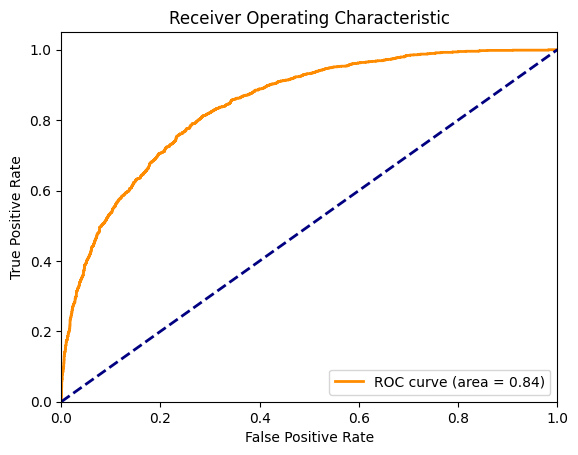

In [11]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()